In [337]:
import os, glob
import cupy as cp
from cupyx.scipy import ndimage as cpx_ndimage  # Import CuPy's GPU ndimage module
import numpy as np
import scipy as sp
import tifffile as tiff
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.widgets import Slider
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128             # to set a higher threshold for maximum .gif size that we can embed here
import glob; import cv2
from scipy import ndimage, misc
from scipy.stats import chi2
from scipy.ndimage import maximum_filter, gaussian_filter, label, find_objects
from sklearn.decomposition import PCA

from scipy.optimize import curve_fit
from skimage.feature import peak_local_max
from natsort import natsorted
import scipy.io as sio
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
import skimage.io as io
from skimage.exposure import adjust_gamma
import imageio
import multiprocessing as mp
import trackpy as tp
import ipywidgets as widgets
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)     # ignore warnings for specific matplotlib commands which will be outdated soon
from IPython.display import display, Image


In [338]:
def convert_to_code_path(windows_path):
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

## Loading the demonstrative movies for spatial correlation study (Flat or Ridges)

In [339]:
# Address where all raw images are (choose 0 for 'flat', 1 for 'ridges')
 
surface = 1

if surface == 0:
    data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min');
    image_path = data_folder+'\\'+'div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tiff'
else:
    data_folder = convert_to_code_path(r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1');
    image_path = data_folder+'\\'+'ridges_19_02_11_C2_ridges_timelapse1_jttr_blch_corr.tiff'

resolution = 2.7778   #px./um
frame_interval = 2.0 #s/frame.

df = pd.read_csv(data_folder+"\\tp_trajectories_final.csv")
img = tiff.imread(image_path) 
im_mean = np.mean(img,axis=0)

In [340]:
df

,frame,y,x,mass,size,ecc,signal,raw_mass,ep,frame.1,particle,x_shift,y_shift,frame_shift,displacement,displacement_scaled,inst_velocity,angle
0,8,310.904762,306.071429,4.779780,1.313198,0.155838,0.699083,37.946982,0.001285,8,250,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,NaN
1,9,309.136452,305.690058,6.200011,1.350042,0.101068,0.797662,40.091894,0.001017,9,250,-0.381370,-1.768310,1.0,1.808967,0.651223,1.808967,1.783212
2,10,307.004396,304.109890,3.599318,1.360349,0.068752,0.458814,23.669978,0.001351,10,250,-1.580168,-2.132057,1.0,2.653789,0.955357,2.653789,2.208608
3,11,305.134670,303.982808,9.310707,1.307169,0.042202,1.333912,60.866699,0.000563,11,250,-0.127082,-1.869725,1.0,1.874039,0.674649,1.874039,1.638660
4,12,116.007353,378.733456,5.845526,1.232972,0.326938,0.945600,33.095495,0.001379,12,352,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,294,58.801587,229.984127,2.411463,1.256728,0.158373,0.325356,15.561495,0.003220,294,7177,-2.034848,2.604244,1.0,3.304950,1.189772,3.304950,-2.234067
617,295,364.171617,249.054455,6.887749,1.250083,0.160027,0.988835,44.887408,0.001335,295,7078,0.114939,2.175649,1.0,2.178683,0.784320,2.178683,-1.518016
618,295,63.078358,228.742537,3.046067,1.233851,0.194999,0.522832,14.392596,0.004164,295,7177,-1.241590,4.276771,1.0,4.453349,1.603193,4.453349,-1.853340
619,296,61.933775,228.701987,17.157080,1.294410,0.148360,2.348210,104.831306,0.001272,296,7177,-0.040551,-1.144583,1.0,1.145301,0.412305,1.145301,1.606210


## Single radii recurrence analysis

In [171]:
def compute_spatial_recurrence_with_counts(df, image_shape, window_size=10, radius=5.0):
    """
    Computes the recurrence fraction of new track start locations across consecutive 
    non-overlapping time windows, while also tracking the number of new track points 
    in each window for context.

    Parameters:
    -----------
    df : pd.DataFrame
        Trackpy dataframe with columns ['frame', 'x', 'y', 'particle'].

    image_shape : tuple
        Shape of the image (height, width). Not used directly, included for consistency.

    window_size : int, default=10
        Number of frames per non-overlapping window.

    radius : float, default=5.0
        Maximum distance (in pixels) to consider two track starts spatially recurrent.

    Returns:
    --------
    pd.DataFrame
        DataFrame with recurrence data including:
        - win1_start, win1_end
        - win2_start, win2_end
        - recurrence_fraction
        - count_win1: number of new tracks in window 1
        - count_win2: number of new tracks in window 2
    """
    import numpy as np
    import pandas as pd
    from scipy.spatial import cKDTree

    new_tracks = df[df['frame'] == df.groupby('particle')['frame'].transform('min')]
    frames = list(range(df['frame'].min(), df['frame'].max() + 1))
    windows = []

    for i in range(0, len(frames) - window_size + 1, window_size):
        win = frames[i:i + window_size]
        coords = new_tracks[new_tracks['frame'].isin(win)][['y', 'x']].values
        windows.append((win, coords))

    records = []
    for (win1, coords1), (win2, coords2) in zip(windows[:-1], windows[1:]):
        count1, count2 = len(coords1), len(coords2)

        if count1 == 0 or count2 == 0:
            frac = np.nan
        else:
            tree = cKDTree(coords1)
            distances, _ = tree.query(coords2, distance_upper_bound=radius)
            n_recurrent = np.sum(distances < radius)
            frac = n_recurrent / count2

        records.append({
            'win1_start': win1[0],
            'win1_end': win1[-1],
            'win2_start': win2[0],
            'win2_end': win2[-1],
            'recurrence_fraction': frac,
            'count_win1': count1,
            'count_win2': count2
        })

    return pd.DataFrame(records)


def plot_spatial_recurrence_with_counts(recurrence_df, min_count_threshold=5):
    """
    Plots recurrence fraction over time using a single line connecting all points.
    Marks reliable and low-data points differently using marker style, but keeps the same color.

    Parameters:
    -----------
    recurrence_df : pd.DataFrame
        Output of compute_spatial_recurrence_with_counts(). Must include:
        - 'win2_start', 'win2_end', 'recurrence_fraction', 'count_win2'

    min_count_threshold : int, default=5
        Minimum number of new tracks in win2 required for a point to be considered reliable.
    """
    import matplotlib.pyplot as plt

    df = recurrence_df.copy()
    df['mid_frame'] = (df['win2_start'] + df['win2_end']) / 2

    reliable = df[df['count_win2'] >= min_count_threshold]
    low_data = df[df['count_win2'] < min_count_threshold]

    plt.figure(figsize=(10, 5))

    # Plot full line (connect all points)
    plt.plot(df['mid_frame'], df['recurrence_fraction'], linestyle='-', color='blue', label='Recurrence trend')

    # Overlay markers
    plt.plot(reliable['mid_frame'], reliable['recurrence_fraction'], linestyle='None',
             marker='o', color='b', label=f"Reliable (n ≥ {min_count_threshold})")

    plt.plot(low_data['mid_frame'], low_data['recurrence_fraction'], linestyle='None',
             marker='x', color='b', label=f"Low-count (n < {min_count_threshold})")

    plt.title("Spatial Recurrence of New Track Start Locations Over Time")
    plt.xlabel("Frame (center of window)")
    plt.ylabel("Recurrence Fraction")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


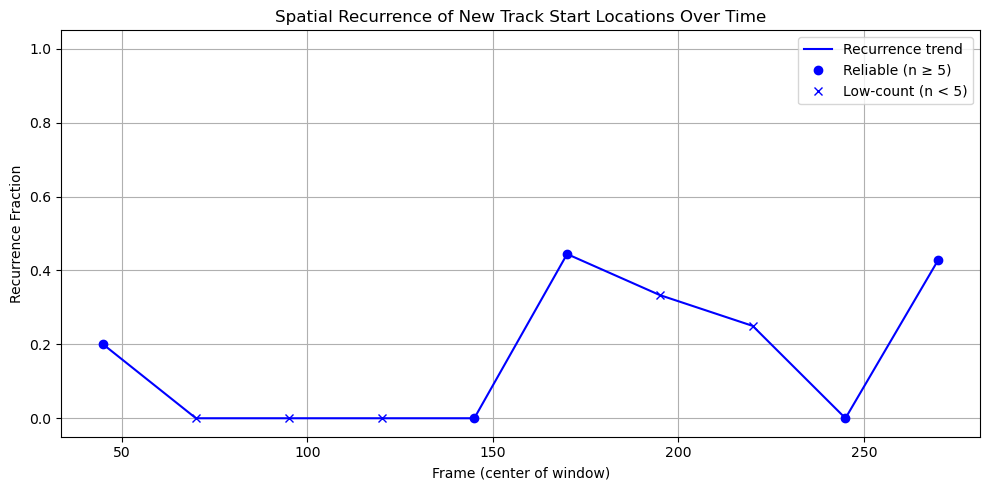

In [218]:
# Parameters
image_shape = np.shape(im_mean)
rec_df = compute_spatial_recurrence_with_counts(df, image_shape, window_size=25, radius=25.0)
plot_spatial_recurrence_with_counts(rec_df)

## Multi-radius Recurrence Analysis

In [341]:
def recurrence_vs_radius(df, image_shape, radius_list, window_size=5):
    """
    Computes recurrence fractions for multiple radii.

    Parameters:
        df (pd.DataFrame): Trackpy dataframe
        image_shape (tuple): (height, width) of the image
        radius_list (list of float): List of radii to evaluate
        window_size (int): Temporal window size

    Returns:
        pd.DataFrame with columns:
            - win1_start, win1_end, win2_start, win2_end, recurrence_fraction, radius
    """
    all_records = []
    for radius in radius_list:
        rec_df = compute_spatial_recurrence_with_counts(df, image_shape, window_size, radius)
        rec_df['radius'] = radius
        all_records.append(rec_df)
    return pd.concat(all_records, ignore_index=True)




## Plotting Function: Radius vs Recurrence

In [342]:
def plot_recurrence_by_radius(recurrence_df, min_count_threshold=5):
    """
    Plots recurrence fraction over time for each radius.
    Draws a single continuous line connecting all points for a given radius,
    while marking reliable and low-data points with different markers.

    Parameters:
        recurrence_df (pd.DataFrame): Output from recurrence_vs_radius()
        min_count_threshold (int): Minimum count of new tracks required to consider a point reliable.
    """
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm

    df_plot = recurrence_df.copy()
    df_plot['radius'] = df_plot['radius'].astype(int)
    df_plot['mid_frame'] = (df_plot['win2_start'] + df_plot['win2_end']) / 2

    unique_radii = sorted(df_plot['radius'].unique())
    color_map = cm.get_cmap('cool', len(unique_radii))

    plt.figure(figsize=(10, 6))

    for i, r in enumerate(unique_radii):
        sub = df_plot[df_plot['radius'] == r]
        reliable = sub[sub['count_win2'] >= min_count_threshold]
        low_data = sub[sub['count_win2'] < min_count_threshold]
        color = color_map(i)

        # Plot full line (all points, no markers)
        plt.plot(sub['mid_frame'], sub['recurrence_fraction'],
                 linestyle='-', color=color, label=f"Radius = {r}px")

        # Overlay markers
        plt.plot(reliable['mid_frame'], reliable['recurrence_fraction'],
                 marker='o', linestyle='None', color=color)
        plt.plot(low_data['mid_frame'], low_data['recurrence_fraction'],
                 marker='x', linestyle='None', color=color)

    plt.title("Spatial Recurrence Over Time for Different Radii")
    plt.xlabel("Frame (center of window)")
    plt.ylabel("Recurrence Fraction")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend(title="Radius")
    plt.tight_layout()
    plt.show()


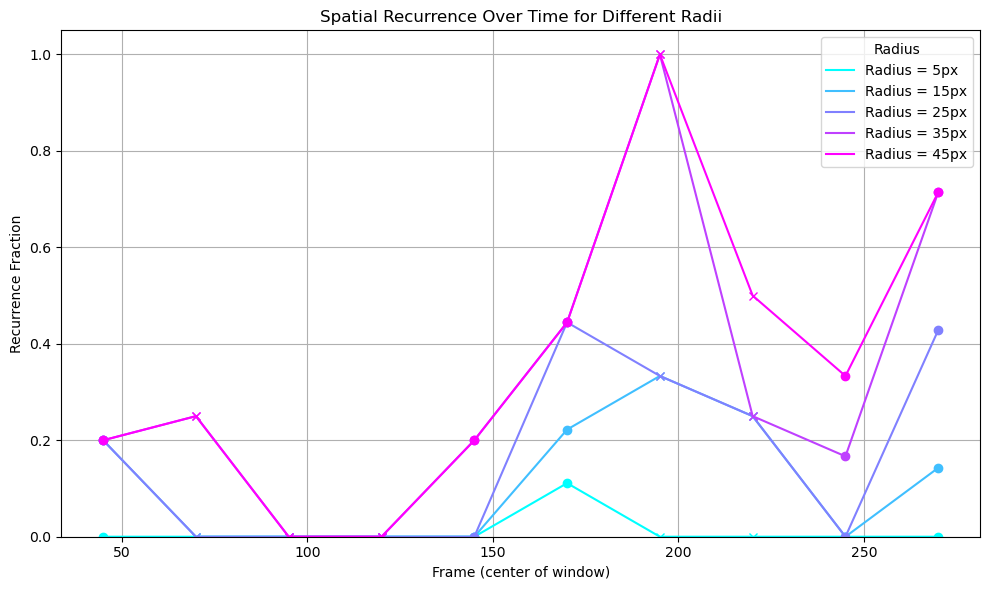

In [209]:
radii = [5, 15, 25, 35, 45]
recurrence_results = recurrence_vs_radius(df, image_shape=(512, 512), radius_list=radii, window_size=25)
plot_recurrence_by_radius(recurrence_results)


## Mean Recurrence vs radius function

In [181]:
def mean_recurrence_vs_radius(df, image_shape, window_size=10, radii=[3, 5, 7, 10], min_count_threshold=5):
    """
    Computes and plots mean recurrence fraction as a function of radius.

    Parameters:
    -----------
    df : pd.DataFrame
        Trackpy dataframe with columns ['frame', 'x', 'y', 'particle'].

    image_shape : tuple
        Shape of the image (height, width).

    window_size : int, default=10
        Number of frames in each non-overlapping window.

    radii : list of float
        List of radii (in pixels) to compute recurrence.

    min_count_threshold : int, default=5
        Minimum number of new tracks in win2 to include recurrence value.

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['radius', 'mean_recurrence'].
    """
    results = []

    for radius in radii:
        rec_df = compute_spatial_recurrence_with_counts(df, image_shape, window_size, radius)
        filtered = rec_df[rec_df['count_win2'] >= min_count_threshold]
        mean_recurrence = filtered['recurrence_fraction'].mean()
        results.append({'radius': radius, 'mean_recurrence': mean_recurrence})

    results_df = pd.DataFrame(results)

    # Plotting
    plt.figure(figsize=(6, 5))
    plt.plot(results_df['radius'], results_df['mean_recurrence'], marker='o')
    plt.title("Mean Recurrence Fraction vs Radius")
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Mean Recurrence Fraction")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df


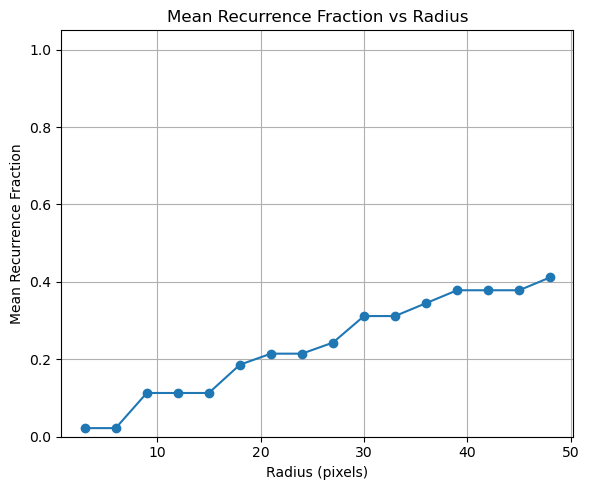

    radius  mean_recurrence
0        3         0.022222
1        6         0.022222
2        9         0.113016
3       12         0.113016
4       15         0.113016
5       18         0.186032
6       21         0.214603
7       24         0.214603
8       27         0.243175
9       30         0.311746
10      33         0.311746
11      36         0.345079
12      39         0.378413
13      42         0.378413
14      45         0.378413
15      48         0.411746


In [203]:
results_df = mean_recurrence_vs_radius(
    df, image_shape=np.shape(im_mean),
    window_size=25,
    radii = np.arange(3,50,3),
    min_count_threshold=5)
print(results_df)


## Load two different dataframes together

In [343]:
# Flat surface
flat_data_folder = convert_to_code_path(
    r'E:\Spandan\2D_Neurons_Paper\Glass\div2\control_div2_glass_2019_01_23_div2cortex_C1_timelapse1_2secPerTP_5min')
flat_image_path = flat_data_folder + '\\' + 'div2cortex_C1_timelapse1_2secPerTP_5min_jttr_blch_corr.tiff'
df_flat = pd.read_csv(flat_data_folder + '\\tp_trajectories_final.csv')
img_flat = tiff.imread(flat_image_path)
im_mean_flat = np.mean(img_flat, axis=0)

# Ridges surface
ridges_data_folder = convert_to_code_path(
    r'E:\Spandan\2D_Neurons_Paper\Ridges\div2\ridges_19_02_11_C2_ridges_timelapse1')
ridges_image_path = ridges_data_folder + '\\' + 'ridges_19_02_11_C2_ridges_timelapse1_jttr_blch_corr.tiff'
df_ridges = pd.read_csv(ridges_data_folder + '\\tp_trajectories_final.csv')
img_ridges = tiff.imread(ridges_image_path)
im_mean_ridges = np.mean(img_ridges, axis=0)

# Shared metadata
resolution = 2.7778   # px/μm
frame_interval = 2.0  # s/frame

## Plot mean recurrence as a function of radius

In [350]:
def mean_recurrence_vs_radius_dual(df_flat, df_ridges, image_shape, window_size=10,
                                   radii=[3, 5, 7, 10], min_count_threshold=5,
                                   resolution=2.7778, frame_interval=2.00137):
    """
    Computes and plots mean recurrence fraction as a function of radius (in microns)
    for both flat and ridged surfaces. Displays time-window in minutes.

    Parameters:
    -----------
    df_flat : pd.DataFrame
        Trackpy dataframe for the flat surface.

    df_ridges : pd.DataFrame
        Trackpy dataframe for the ridged surface.

    image_shape : tuple
        Shape of the image (height, width).

    window_size : int
        Number of frames in each non-overlapping window.

    radii : list of float
        Radii (in pixels) at which to evaluate recurrence.

    min_count_threshold : int
        Minimum number of new tracks in win2 to include the recurrence value.

    resolution : float
        Microns per pixel (μm/px).

    frame_interval : float
        Time between frames (s/frame).

    Returns:
    --------
    tuple of pd.DataFrame
        (results_flat, results_ridges) — DataFrames with ['radius_um', 'mean_recurrence']
    """
    results_flat = []
    results_ridges = []

    color_labels = ['#E1BE6A', '#40B0A6']  # Colors for Flat and Ridge
    marker_labels = ["s", "X"]  # Markers for Flat and Ridge

    for radius in radii:
        # Flat surface
        rec_flat = compute_spatial_recurrence_with_counts(df_flat, image_shape, window_size, radius)
        filtered_flat = rec_flat[rec_flat['count_win2'] >= min_count_threshold]
        mean_flat = filtered_flat['recurrence_fraction'].mean()
        results_flat.append({'radius_um': radius / resolution, 'mean_recurrence': mean_flat})

        # Ridges surface
        rec_ridges = compute_spatial_recurrence_with_counts(df_ridges, image_shape, window_size, radius)
        filtered_ridges = rec_ridges[rec_ridges['count_win2'] >= min_count_threshold]
        mean_ridges = filtered_ridges['recurrence_fraction'].mean()
        results_ridges.append({'radius_um': radius / resolution, 'mean_recurrence': mean_ridges})

    df_results_flat = pd.DataFrame(results_flat)
    df_results_ridges = pd.DataFrame(results_ridges)

    # Convert time-window to minutes
    time_window_min = (window_size * frame_interval) / 60

    # Plotting
    plt.figure(figsize=(6, 6))

    plt.plot(df_results_flat['radius_um'], df_results_flat['mean_recurrence'], marker=marker_labels[0], 
             color=color_labels[0], markeredgecolor='black', markeredgewidth=1.0, markersize=9, linewidth=1.5, 
             alpha=1.0, label='Flat, DIV 2')

    plt.plot(df_results_ridges['radius_um'], df_results_ridges['mean_recurrence'], marker=marker_labels[1], 
             color=color_labels[1], markeredgecolor='black', markeredgewidth=1.0, markersize=9, linewidth=1.5, 
             alpha=1.0, label='Ridge, DIV 2')

    plt.title(f"Time-window = {time_window_min:.2f} min", fontsize=20)
    plt.xlabel("Radius (μm)", fontsize=20)
    plt.ylabel("Mean recurrence", fontsize=20)
    plt.ylim(-0.1, 1.05)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=16, loc='upper left')
    plt.tight_layout()

    # Save figure
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Combined Plots_glass_vs_ridge\\flat_vs_ridge_mean_recurrence_vs_radius.svg',
                format='svg', bbox_inches='tight')
    plt.show()

    return df_results_flat, df_results_ridges


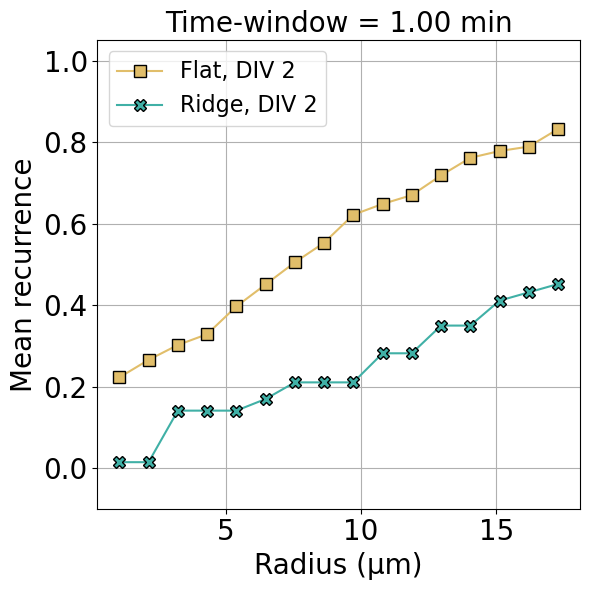

In [351]:
results_flat, results_ridges = mean_recurrence_vs_radius_dual(
    df_flat, df_ridges,
    image_shape=img_flat.shape[1:],  # assuming same shape
    window_size=30,
    radii = np.arange(3,50,3),
    min_count_threshold=3
)


## Plot mean recurrence as a function of time-windows

In [348]:
def mean_recurrence_vs_window_dual(df_flat, df_ridges, image_shape, 
                                   window_sizes=[5, 10, 15, 20, 25], 
                                   radius=25, min_count_threshold=5,
                                   resolution=2.7778, frame_interval=2.00137):
    """
    Computes and plots mean recurrence fraction as a function of time-window (in minutes)
    for both flat and ridged surfaces.

    Parameters:
    -----------
    df_flat : pd.DataFrame
        Trackpy dataframe for the flat surface.

    df_ridges : pd.DataFrame
        Trackpy dataframe for the ridged surface.

    image_shape : tuple
        Shape of the image (height, width).

    window_sizes : list of int
        List of temporal window sizes (in frames) to evaluate recurrence over.

    radius : float
        Radius (in pixels) to evaluate recurrence at.

    min_count_threshold : int
        Minimum number of new tracks in win2 to include recurrence value.

    resolution : float
        Microns per pixel (μm/px).

    frame_interval : float
        Time between frames (s/frame).

    Returns:
    --------
    tuple of pd.DataFrame
        (results_flat, results_ridges) — DataFrames with ['time_window_min', 'mean_recurrence']
    """
    results_flat = []
    results_ridges = []

    color_labels = ['#E1BE6A', '#40B0A6']  # Colors for Flat and Ridge
    marker_labels = ["s", "X"]  # Markers for Flat and Ridge

    for win in window_sizes:
        time_min = (win * frame_interval) / 60

        # Flat surface
        rec_flat = compute_spatial_recurrence_with_counts(df_flat, image_shape, win, radius)
        filtered_flat = rec_flat[rec_flat['count_win2'] >= min_count_threshold]
        mean_flat = filtered_flat['recurrence_fraction'].mean()
        results_flat.append({'time_window_min': time_min, 'mean_recurrence': mean_flat})

        # Ridges surface
        rec_ridges = compute_spatial_recurrence_with_counts(df_ridges, image_shape, win, radius)
        filtered_ridges = rec_ridges[rec_ridges['count_win2'] >= min_count_threshold]
        mean_ridges = filtered_ridges['recurrence_fraction'].mean()
        results_ridges.append({'time_window_min': time_min, 'mean_recurrence': mean_ridges})

    df_results_flat = pd.DataFrame(results_flat)
    df_results_ridges = pd.DataFrame(results_ridges)

    # Convert radius to microns
    radius_um = radius / resolution

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(df_results_flat['time_window_min'], df_results_flat['mean_recurrence'], marker=marker_labels[0], 
             color=color_labels[0], markeredgecolor='black', markeredgewidth=1.0, markersize=9, linewidth=1.5, 
             alpha=1.0, label='Flat, DIV 2')
    plt.plot(df_results_ridges['time_window_min'], df_results_ridges['mean_recurrence'], marker=marker_labels[1], 
             color=color_labels[1], markeredgecolor='black', markeredgewidth=1.0, markersize=9, linewidth=1.5, 
             alpha=1.0, label='Ridge, DIV 2')

    plt.title(f"Radius = {radius_um:.1f} μm", fontsize=20)
    plt.xlabel("Time-window (min)", fontsize=20)
    plt.ylabel("Mean recurrence", fontsize=20)
    plt.ylim(-0.1, 1.05)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=16, loc='upper left')
    plt.tight_layout()
    plt.savefig('E:\\Spandan\\2D_Neurons_Paper\\Combined Plots_glass_vs_ridge\\flat_vs_ridge_mean_recurrence_vs_time_window.svg',
                format='svg', bbox_inches='tight')
    plt.show()

    return df_results_flat, df_results_ridges


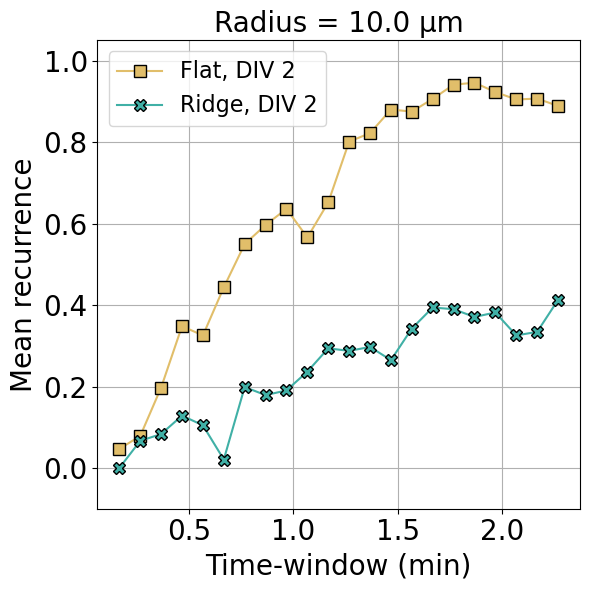

In [349]:
results_flat, results_ridges = mean_recurrence_vs_window_dual(
    df_flat, df_ridges,
    image_shape=img_flat.shape[1:],  # assuming same shape
    window_sizes=np.arange(5, 70, 3),
    radius=27.78,
    resolution=2.7778,
    frame_interval=2.00137,
    min_count_threshold=3
)

